# Introduction

This notebook trains a LSTM model that predicts the close price of EURUSD 15 minutes in the future by looking at last five hours of data.

A0218936U Li Yongzhen

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Data/EURUSD_M15.csv')
df.head()

,Unnamed: 0,Date,Open,Close,High,Low,Volume
0,0,1999-02-12 09:15:00,1.1246,1.1236,1.1234,1.1250,89
1,1,1999-02-12 09:30:00,1.1237,1.1237,1.1234,1.1241,73
2,2,1999-02-12 09:45:00,1.1239,1.1237,1.1232,1.1244,86
3,3,1999-02-12 10:00:00,1.1239,1.1241,1.1232,1.1246,111
4,4,1999-02-12 10:15:00,1.1239,1.1222,1.1217,1.1241,116


In [4]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515200 entries, 0 to 515199
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    515200 non-null  object 
 1   Open    515200 non-null  float64
 2   Close   515200 non-null  float64
 3   High    515200 non-null  float64
 4   Low     515200 non-null  float64
 5   Volume  515200 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 23.6+ MB


In [5]:
df.rename(columns={'Date' : 'timestamp', 'Open' : 'open', 'Close' : 'close', 
                   'High' : 'high', 'Low' : 'low', 'Close' : 'close', 'Volume' : 'volume'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.set_index('timestamp', inplace=True)
df = df.astype(float)
df.head()

,open,close,high,low,volume
timestamp,,,,,
1999-02-12 09:15:00,1.1246,1.1236,1.1234,1.1250,89.0
1999-02-12 09:30:00,1.1237,1.1237,1.1234,1.1241,73.0
1999-02-12 09:45:00,1.1239,1.1237,1.1232,1.1244,86.0
1999-02-12 10:00:00,1.1239,1.1241,1.1232,1.1246,111.0
1999-02-12 10:15:00,1.1239,1.1222,1.1217,1.1241,116.0


In [6]:
# Add additional features
df['hour'] = df.index.hour
df['day']  = df.index.weekday
df['week'] = df.index.isocalendar().week
df['momentum']  = df['volume'] * (df['open'] - df['close'])
df['avg_price'] = (df['low'] + df['high'])/2
df['range']     = df['high'] - df['low']
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close'])/4
df['oc_diff']    = df['open'] - df['close']

In [7]:
# Add PCA as a feature instead of for reducing the dimensionality.
from sklearn.decomposition import PCA

dataset = df.copy().values.astype('float32')
pca_features = df.columns.tolist()

pca = PCA(n_components=1)
df['pca'] = pca.fit_transform(dataset)

As observed above, using PCA shows data seperability that somehwat clusters the data into different price groups.

In [9]:
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [18]:
df1 = df[df.index>='2010-01-01']
df2 = df1[df1.index<'2017-04-01']
df_train = df2[df2.index<'2017-01-01']
df_test = df2[df2.index>='2017-01-01']

In [19]:
# Scale and create datasets
target_index_train = df_train.columns.tolist().index('close')
target_index_test = df_test.columns.tolist().index('close')
high_index = df.columns.tolist().index('high')
low_index = df.columns.tolist().index('low')
#dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_set = scaler.fit_transform(df_train)
test_set = scaler.transform(df_test)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df_train['close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)
    
# Set look_back to 20 which is 5 hours (15min*20)
X_train, y_train = create_dataset(train_set, look_back=20)
X_test, y_test = create_dataset(test_set, look_back=20)
y_train = y_train[:,target_index_train]
y_test = y_test[:,target_index_test]

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense

# create a small LSTM network
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 20)            2800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 10)            1240      
_________________________________________________________________
dropout (Dropout)            (None, 20, 10)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

In [22]:
# Save the best weight during training.
from keras.callbacks import ModelCheckpoint
weights_path = "/content/drive/MyDrive/Data/best_weight.hdf5"
checkpoint = ModelCheckpoint(weights_path, monitor='val_mse', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=500, verbose=1, callbacks=callbacks_list, validation_split=0.1)#epochs = 200,batch_size=500

Epoch 1/100
312/312 [==============================] - 11s 14ms/step - loss: 0.2116 - mae: 0.3913 - mse: 0.2116 - val_loss: 0.0017 - val_mae: 0.0251 - val_mse: 0.0017

Epoch 00001: val_mse improved from inf to 0.00167, saving model to /content/drive/MyDrive/Data/best_weight.hdf5
Epoch 2/100
312/312 [==============================] - 3s 10ms/step - loss: 0.0015 - mae: 0.0241 - mse: 0.0015 - val_loss: 0.0016 - val_mae: 0.0217 - val_mse: 0.0016

Epoch 00002: val_mse improved from 0.00167 to 0.00156, saving model to /content/drive/MyDrive/Data/best_weight.hdf5
Epoch 3/100
312/312 [==============================] - 3s 10ms/step - loss: 2.9752e-04 - mae: 0.0110 - mse: 2.9752e-04 - val_loss: 0.0014 - val_mae: 0.0204 - val_mse: 0.0014

Epoch 00003: val_mse improved from 0.00156 to 0.00144, saving model to /content/drive/MyDrive/Data/best_weight.hdf5
Epoch 4/100
312/312 [==============================] - 3s 10ms/step - loss: 2.1996e-04 - mae: 0.0093 - mse: 2.1996e-04 - val_loss: 0.0013 - val_ma

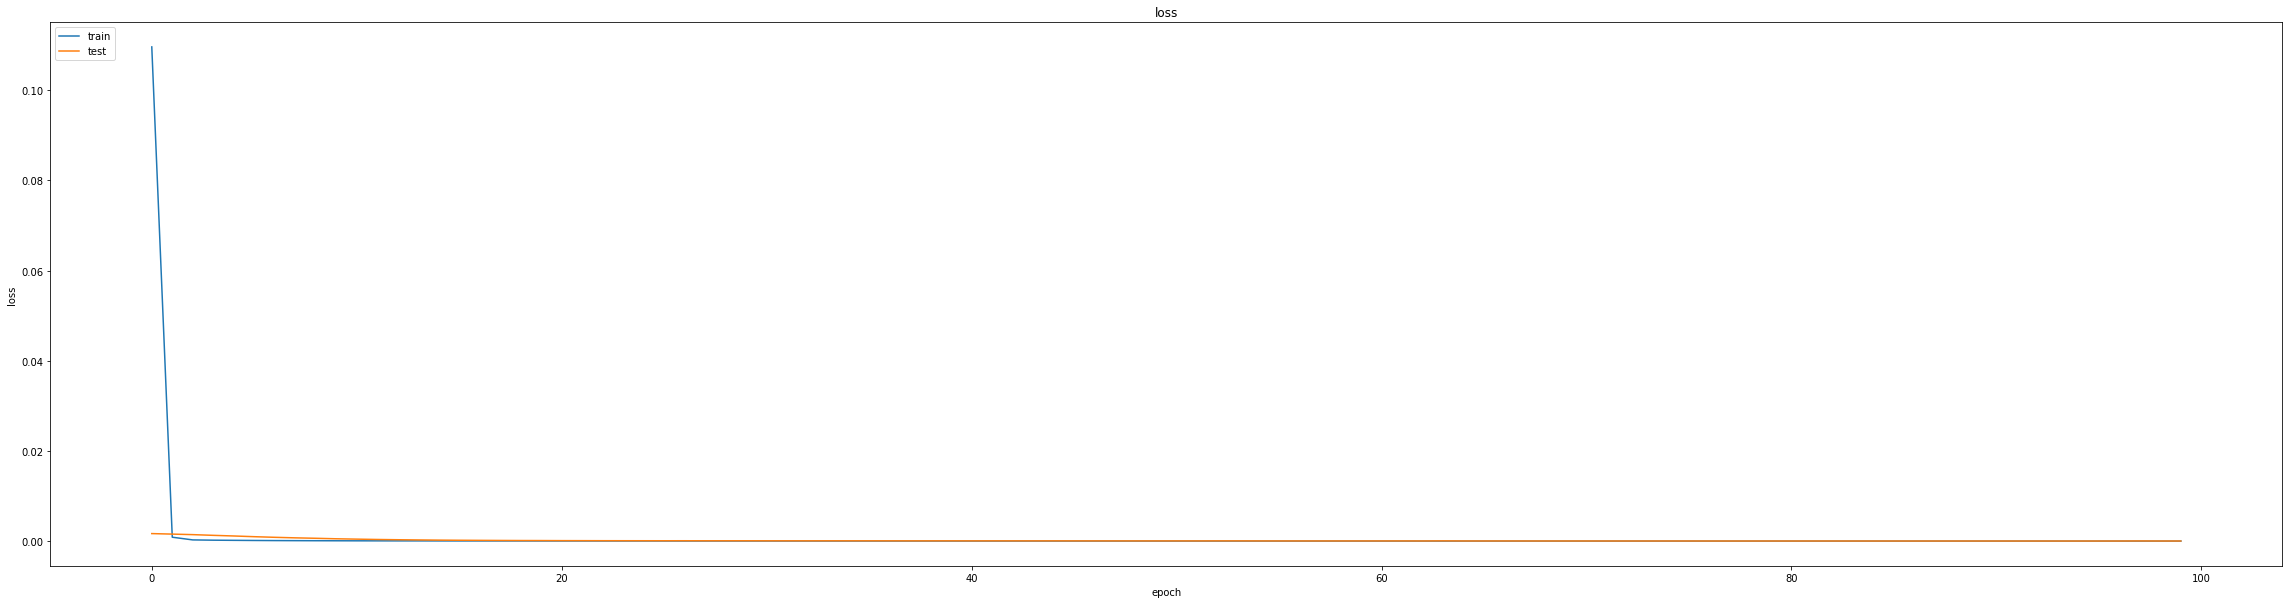

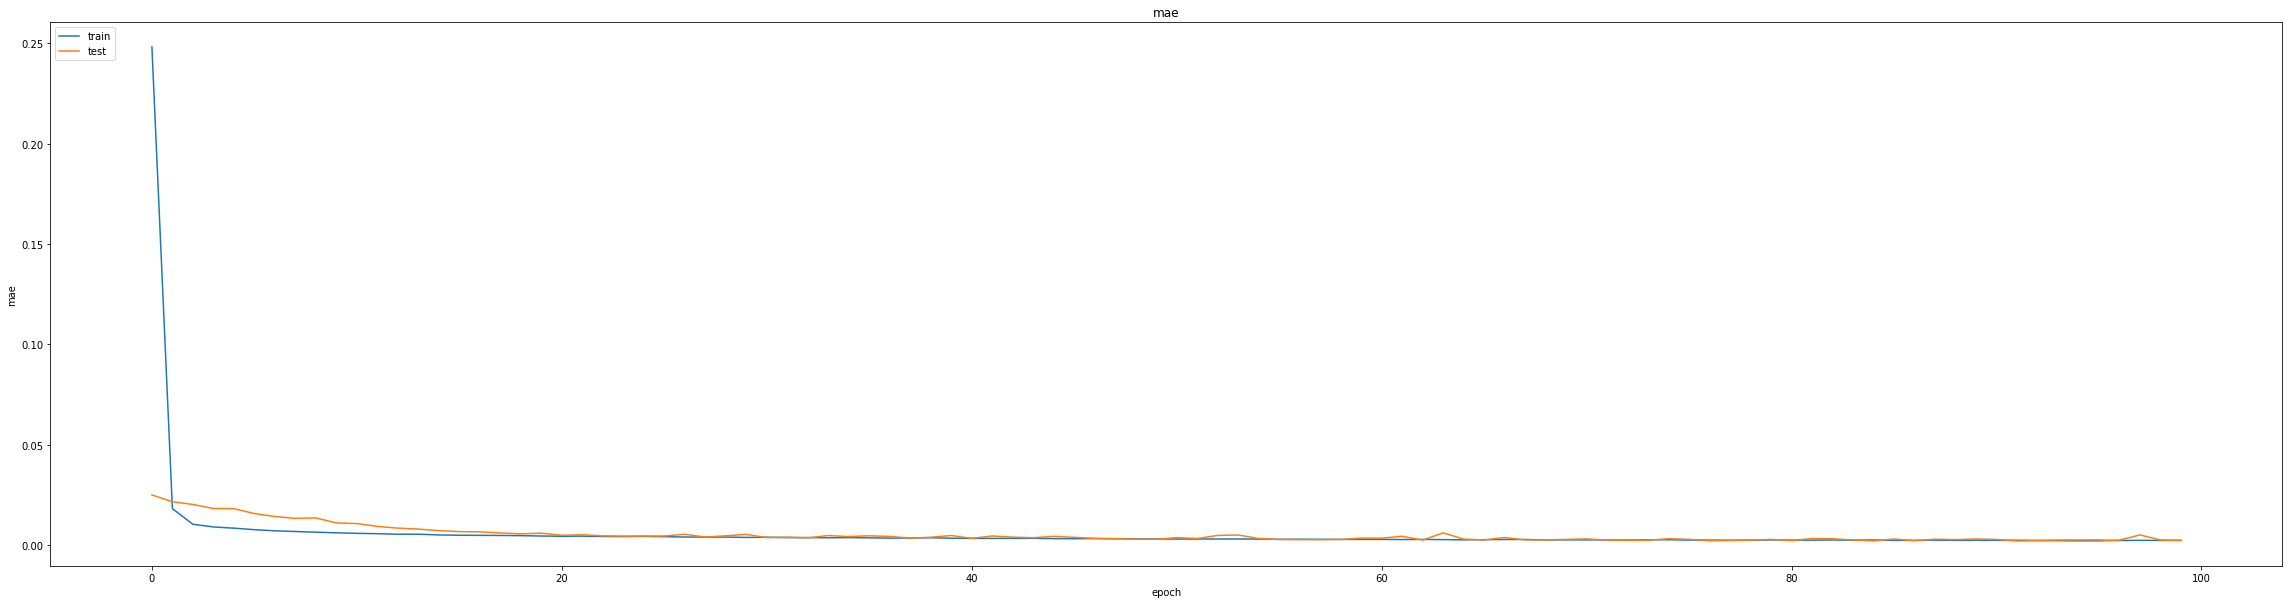

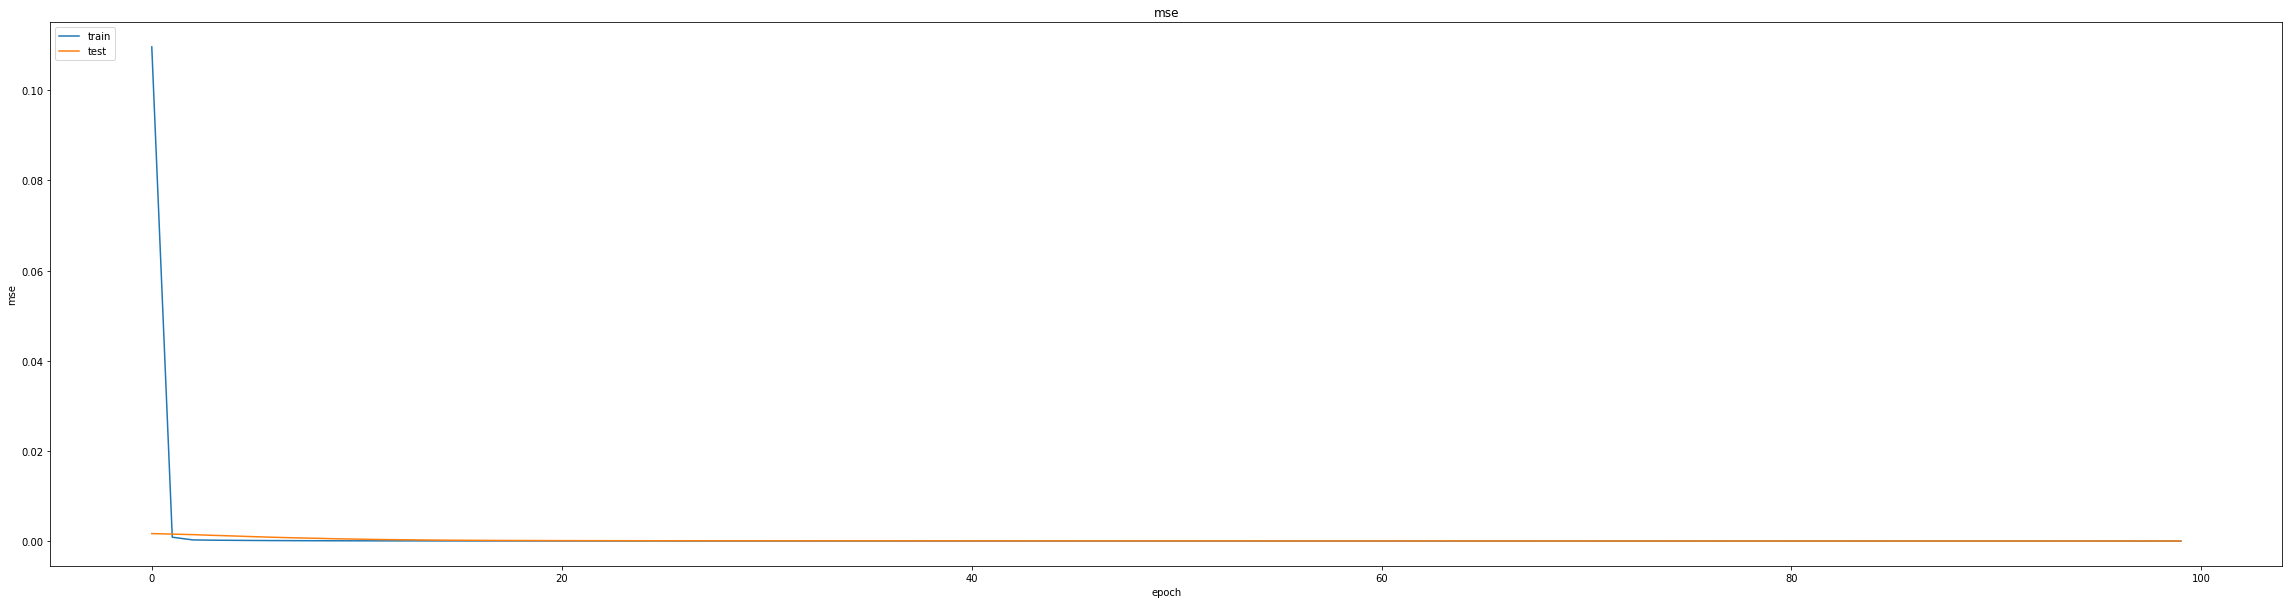

In [23]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [24]:
min(history.history['val_mae'])

0.002121580997481942

Go back to the best weight, and decay the learning rate while retraining the model

In [25]:
# Baby the model a bit
# Load the weight that worked the best
model.load_weights(weights_path)

# Train again with decaying learning rate
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, lr_decay]
history = model.fit(X_train, y_train, epochs=50, batch_size=500, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/50
312/312 [==============================] - 3s 10ms/step - loss: 1.2189e-05 - mae: 0.0026 - mse: 1.2189e-05 - val_loss: 2.6959e-05 - val_mae: 0.0027 - val_mse: 2.6959e-05

Epoch 00001: val_mse did not improve from 0.00003
Epoch 2/50
312/312 [==============================] - 3s 10ms/step - loss: 1.0616e-05 - mae: 0.0024 - mse: 1.0616e-05 - val_loss: 2.6060e-05 - val_mae: 0.0021 - val_mse: 2.6060e-05

Epoch 00002: val_mse did not improve from 0.00003
Epoch 3/50
lr changed to 0.0009000000427477062
312/312 [==============================] - 3s 10ms/step - loss: 1.0454e-05 - mae: 0.0024 - mse: 1.0454e-05 - val_loss: 2.5333e-05 - val_mae: 0.0022 - val_mse: 2.5333e-05

Epoch 00003: val_mse did not improve from 0.00003
Epoch 4/50
312/312 [==============================] - 3s 10ms/step - loss: 1.0644e-05 - mae: 0.0025 - mse: 1.0644e-05 - val_loss: 2.7806e-05 - val_mae: 0.0029 - val_mse: 2.7806e-05

Epoch 00004: val_mse did not improve from 0.00003
Epoch 5/50
lr changed to 0.000810000

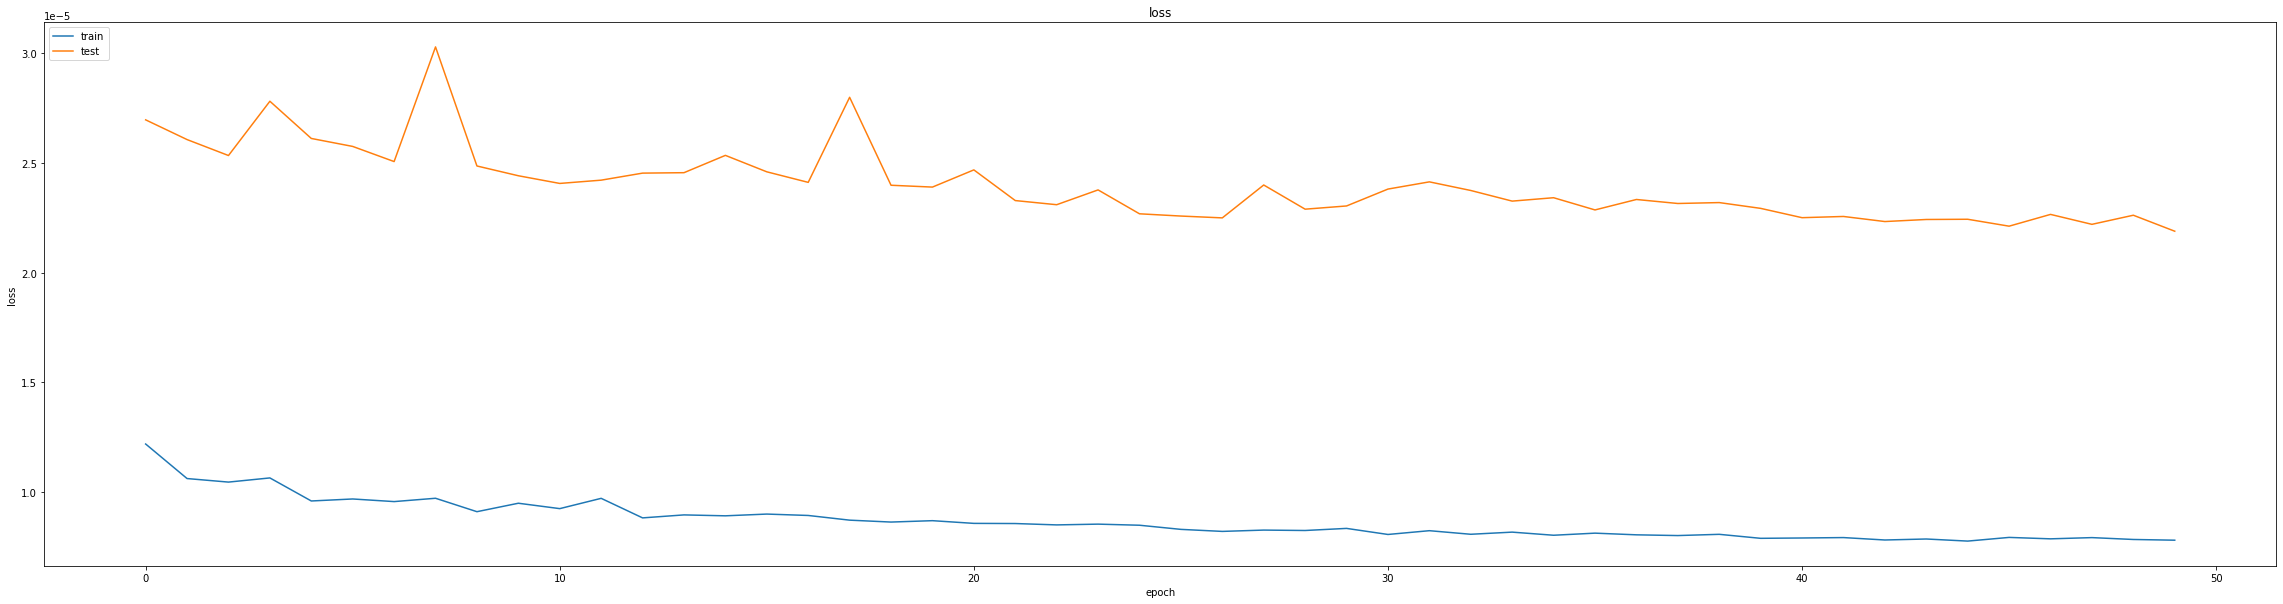

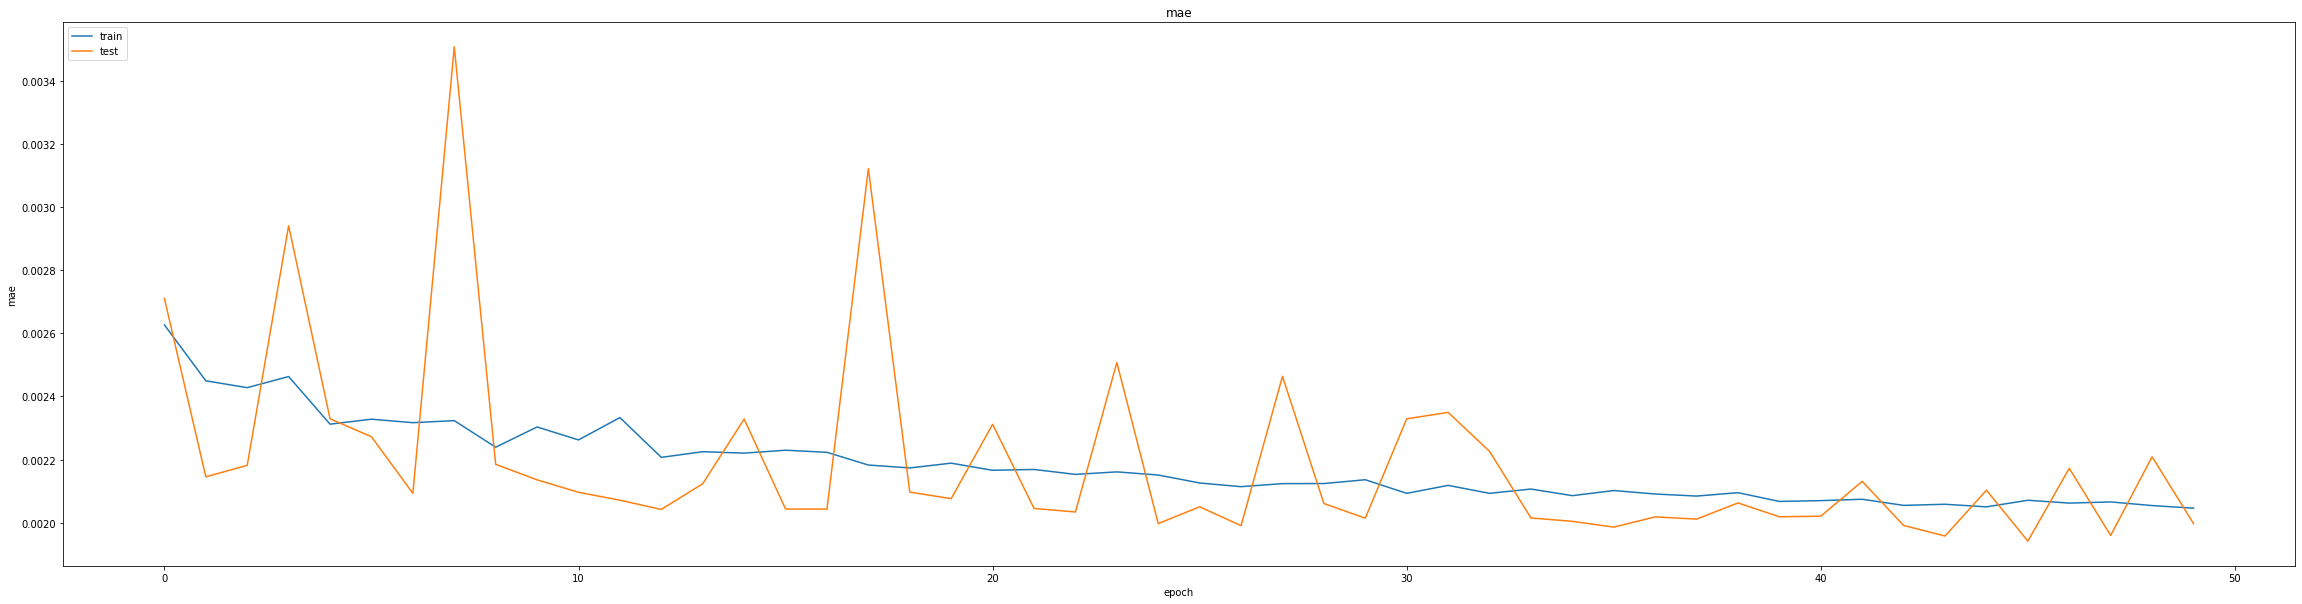

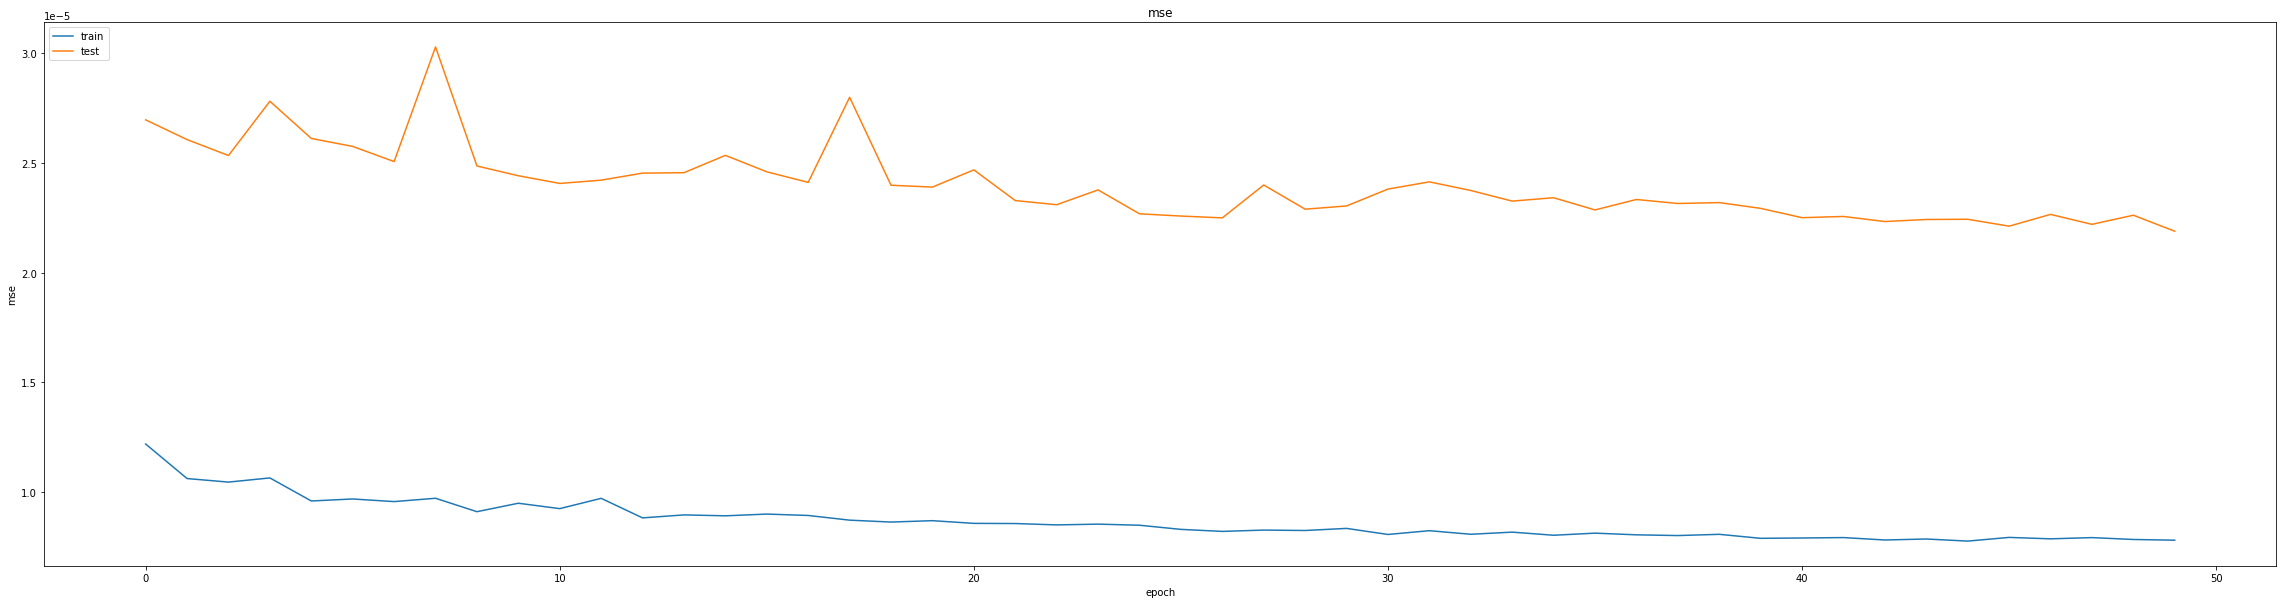

KeyError: ignored

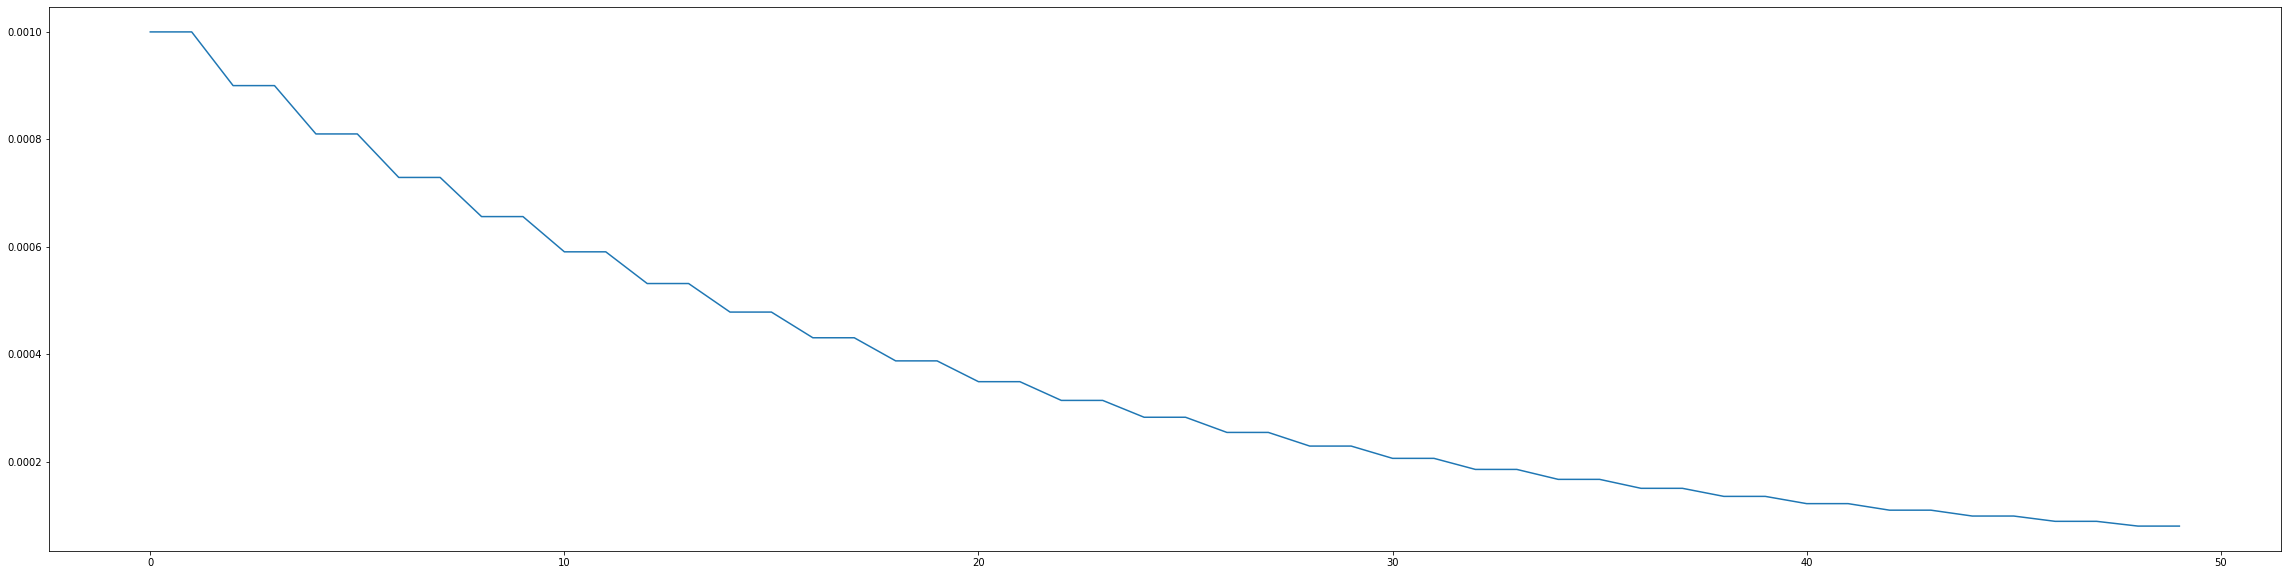

In [26]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [27]:
min(history.history['val_mae'])

0.001941708498634398

# Visually compare the prediction and actual (scaled values)

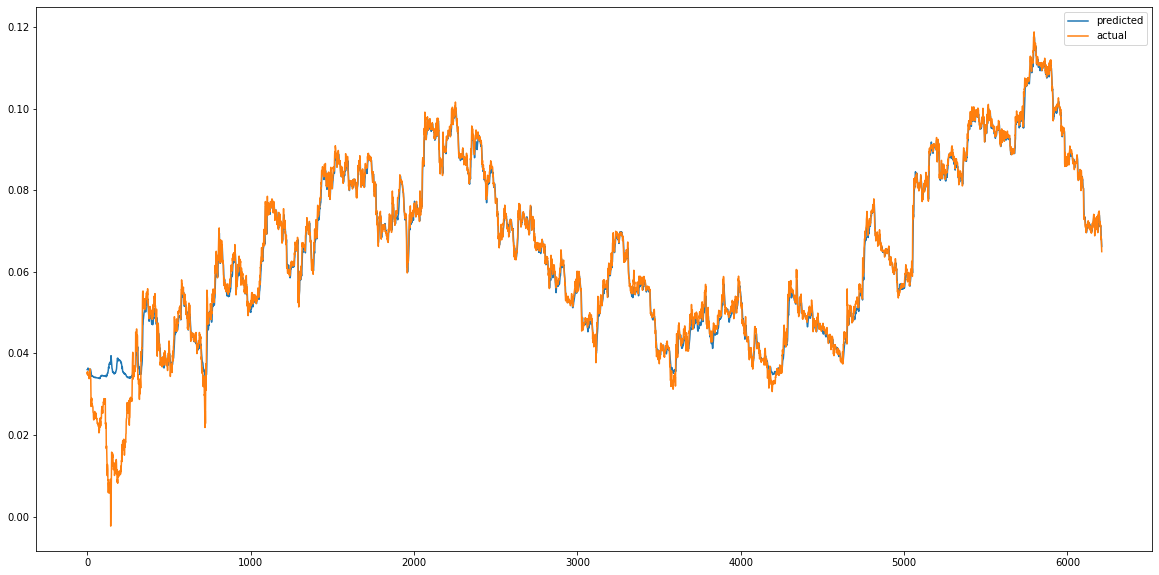

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


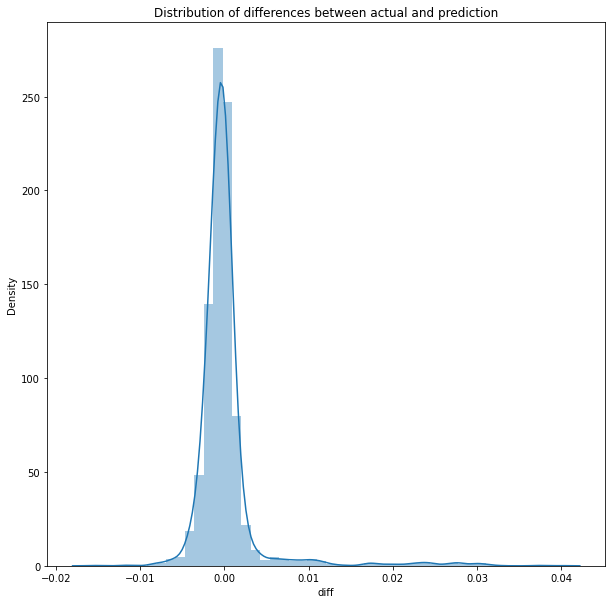

MSE :  1.6776888151918875e-05
MAE :  0.0018574094869108564
MAPE:  3.95180909393054


count    6211.000000
mean        0.000143
std         0.004094
min        -0.015906
25%        -0.001316
50%        -0.000397
75%         0.000490
max         0.040092
Name: diff, dtype: float64

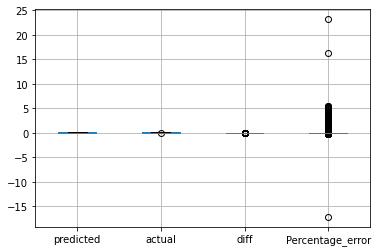

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Benchmark
model.load_weights(weights_path)

pred = model.predict(X_test)

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = y_test
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
predictions['Percentage_error'] = (predictions['predicted'] - predictions['actual'])/predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()
'''
sns.distplot(predictions['Percentage_error'])
plt.title('Distribution of percentage error between actual and prediction')
plt.show()
'''
predictions.boxplot()

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
print("MAPE: ", mape(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

# Compare the unscaled values and see if the prediction falls within the Low and High

In [38]:
df_test.head(30)

,open,close,high,low,volume,hour,day,week,momentum,avg_price,range,ohlc_price,oc_diff,pca
timestamp,,,,,,,,,,,,,,
2017-01-02 00:00:00,1.05127,1.05153,1.04500,1.05234,75874.0,0,0,1,-19.72724,1.048670,-0.00734,1.050035,-0.00026,74912.968750
2017-01-02 00:15:00,1.05167,1.05148,1.05098,1.05176,148.0,0,0,1,0.02812,1.051370,-0.00078,1.051473,0.00019,-813.015137
2017-01-02 00:30:00,1.05148,1.05150,1.05140,1.05191,121.0,0,0,1,-0.00242,1.051655,-0.00051,1.051573,-0.00002,-840.015137
2017-01-02 00:45:00,1.05162,1.05168,1.05142,1.05192,116.0,0,0,1,-0.00696,1.051670,-0.00050,1.051660,-0.00006,-845.015381
2017-01-02 01:00:00,1.05172,1.05239,1.05172,1.05270,140.0,1,0,1,-0.09380,1.052210,-0.00098,1.052132,-0.00067,-821.015198
2017-01-02 01:15:00,1.05239,1.05236,1.05180,1.05239,89.0,1,0,1,0.00267,1.052095,-0.00059,1.052235,0.00003,-872.015076
2017-01-02 01:30:00,1.05213,1.05234,1.05192,1.05275,106.0,1,0,1,-0.02226,1.052335,-0.00083,1.052285,-0.00021,-855.015198
2017-01-02 01:45:00,1.05236,1.05224,1.05192,1.05238,136.0,1,0,1,0.01632,1.052150,-0.00046,1.052225,0.00012,-825.015381
2017-01-02 02:00:00,1.05223,1.05190,1.05155,1.05224,72.0,2,0,1,0.02376,1.051895,-0.00069,1.051980,0.00033,-889.015320


In [39]:
pred = model.predict(X_test)
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1)))
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

In [43]:
predictions.tail()

,predicted,close
6206,1.067305,1.06663
6207,1.066638,1.06692
6208,1.066723,1.06640
6209,1.066366,1.06575
6210,1.065863,1.06528


In [41]:
predicted_test = df_test[df_test.index>='2017-01-02 05:00:00']
predicted_test.head()

,open,close,high,low,volume,hour,day,week,momentum,avg_price,range,ohlc_price,oc_diff,pca
timestamp,,,,,,,,,,,,,,
2017-01-02 05:00:00,1.05151,1.05171,1.05144,1.05171,356.0,5,0,1,-0.07120,1.051575,-0.00027,1.051593,-0.00020,-605.015930
2017-01-02 05:15:00,1.05155,1.05151,1.05138,1.05171,265.0,5,0,1,0.01060,1.051545,-0.00033,1.051537,0.00004,-696.015869
2017-01-02 05:30:00,1.05151,1.05180,1.05130,1.05188,118.0,5,0,1,-0.03422,1.051590,-0.00058,1.051623,-0.00029,-843.015808
2017-01-02 05:45:00,1.05150,1.05184,1.05142,1.05214,147.0,5,0,1,-0.04998,1.051780,-0.00072,1.051725,-0.00034,-814.015625
2017-01-02 06:00:00,1.05184,1.05179,1.05130,1.05190,113.0,6,0,1,0.00565,1.051600,-0.00060,1.051708,0.00005,-848.015808


In [55]:
predicted_test=predicted_test[predicted_test.index<'2017-03-31 23:45:00']
predicted_test.tail()

,open,close,high,low,volume,hour,day,week,momentum,avg_price,range,ohlc_price,oc_diff,pca
timestamp,,,,,,,,,,,,,,
2017-03-31 22:30:00,1.06714,1.06663,1.06652,1.06739,1163.0,22,4,13,0.59313,1.066955,-0.00087,1.066920,0.00051,201.982269
2017-03-31 22:45:00,1.06665,1.06692,1.06642,1.06699,1316.0,22,4,13,-0.35532,1.066705,-0.00057,1.066745,-0.00027,354.981903
2017-03-31 23:00:00,1.06694,1.06640,1.06620,1.06715,1101.0,23,4,13,0.59454,1.066675,-0.00095,1.066672,0.00054,139.982086
2017-03-31 23:15:00,1.06640,1.06575,1.06554,1.06640,1143.0,23,4,13,0.74295,1.065970,-0.00086,1.066022,0.00065,181.981964
2017-03-31 23:30:00,1.06574,1.06528,1.06513,1.06585,687.0,23,4,13,0.31602,1.065490,-0.00072,1.065500,0.00046,-274.017883


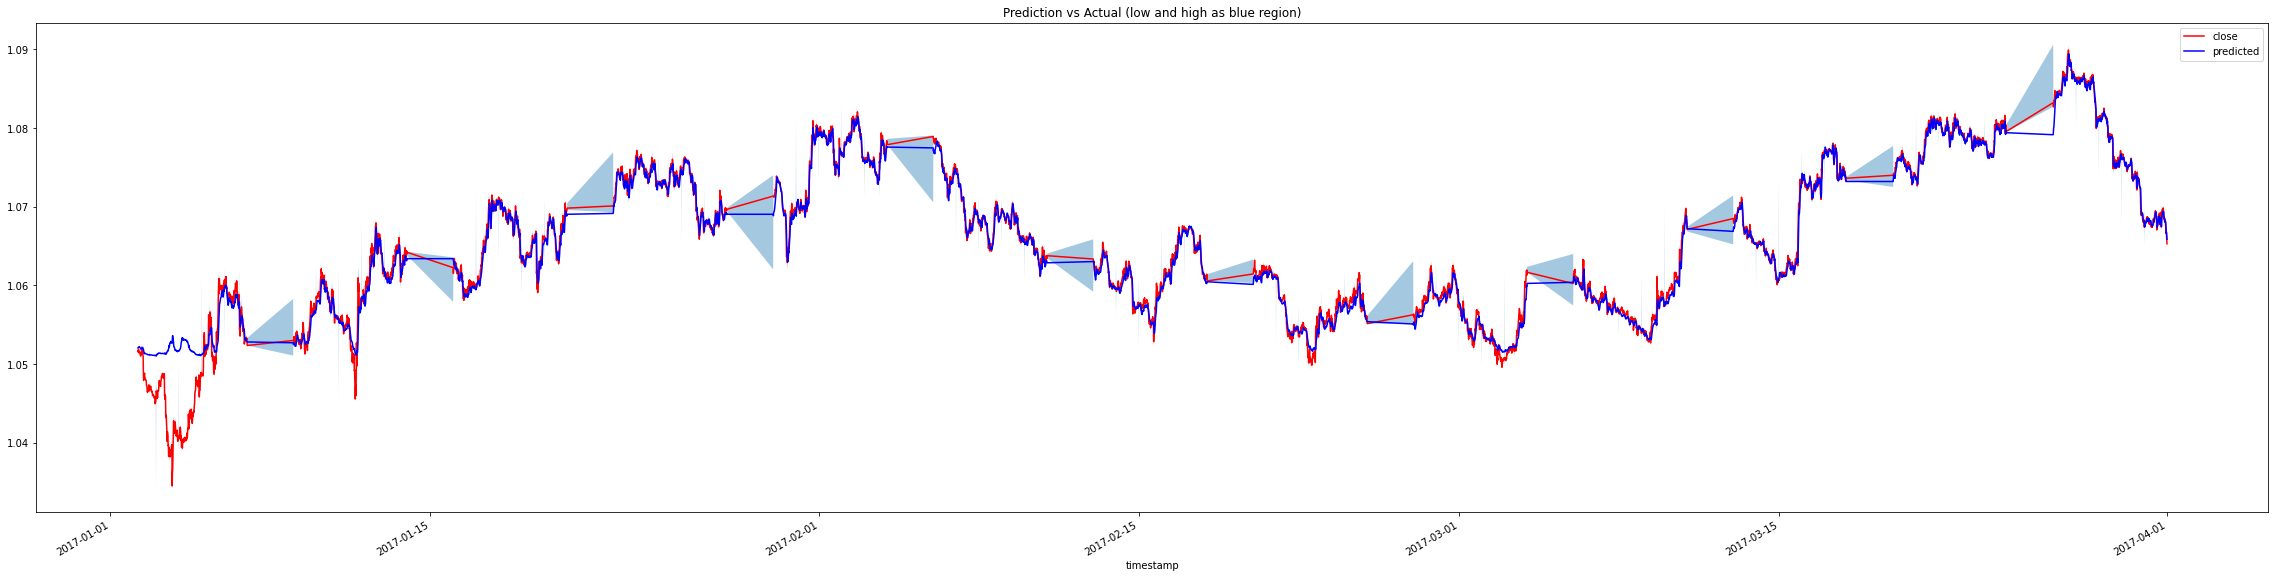

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


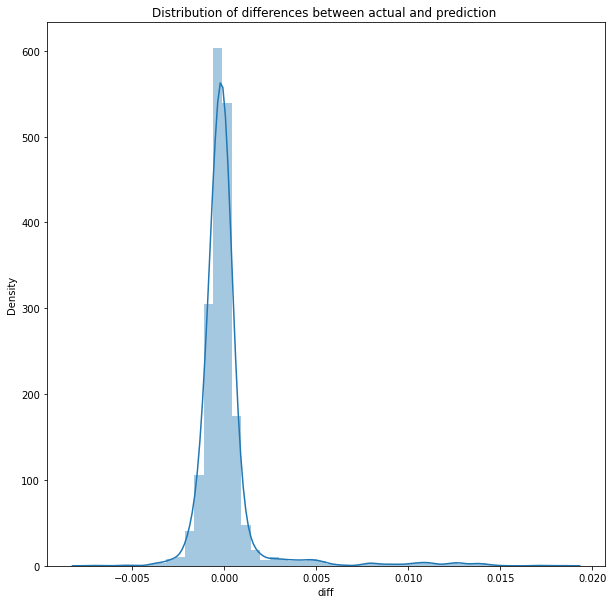

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


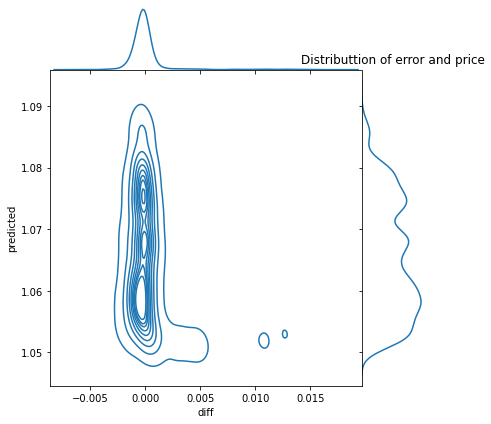

MSE :  3.5135062011185883e-06
MAE :  0.0008500066157052468


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


count    6211.000000
mean        0.000065
std         0.001873
min        -0.007279
25%        -0.000602
50%        -0.000182
75%         0.000224
max         0.018347
Name: diff, dtype: float64

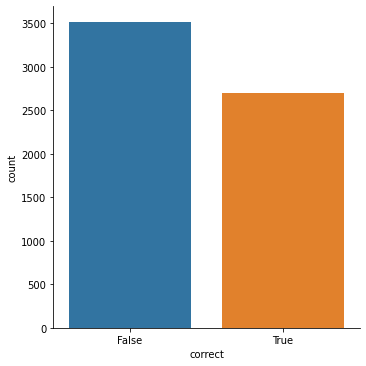

In [56]:
pred = model.predict(X_test)
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1)))
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

p = predicted_test
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low', 'high']], right_index=True, left_index=True)

ax = predictions.plot(y='close', c='red', figsize=(40,10),use_index=True)#x=predictions.index, 
ax = predictions.plot(y='predicted', c='blue', figsize=(40,10), ax=ax, use_index=True)#x=predictions.index
index = [str(item) for item in predictions.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['close']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

g = sns.jointplot("diff", "predicted", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

predictions['correct'] = (predictions['predicted'] <= predictions['low']) & (predictions['predicted'] >= predictions['high'])
sns.factorplot(data=predictions, x='correct', kind='count')

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
predictions['diff'].describe()

The above references an opinion and is for information purposes only.  It is not intended to be investment advice.  Seek a duly licensed professional for investment advice.

In [59]:
predictions.head()

,predicted,close,low,high,diff,correct
timestamp,,,,,,
2017-01-02 05:00:00,1.052039,1.05171,1.05171,1.05144,0.000329,False
2017-01-02 05:15:00,1.052071,1.05151,1.05171,1.05138,0.000561,False
2017-01-02 05:30:00,1.052083,1.05180,1.05188,1.05130,0.000283,False
2017-01-02 05:45:00,1.052094,1.05184,1.05214,1.05142,0.000254,True
2017-01-02 06:00:00,1.052134,1.05179,1.05190,1.05130,0.000344,False


In [61]:
predictions['percentage_error']=abs(predictions['diff'])/predictions['close']
predictions['error_to_range'] = abs(predictions['diff']/(predictions['low']-predictions['high']))
predictions.head()

,predicted,close,low,high,diff,correct,percentage_error,error_to_range
timestamp,,,,,,,,
2017-01-02 05:00:00,1.052039,1.05171,1.05171,1.05144,0.000329,False,0.000313,1.217316
2017-01-02 05:15:00,1.052071,1.05151,1.05171,1.05138,0.000561,False,0.000534,1.701387
2017-01-02 05:30:00,1.052083,1.05180,1.05188,1.05130,0.000283,False,0.000269,0.487762
2017-01-02 05:45:00,1.052094,1.05184,1.05214,1.05142,0.000254,True,0.000241,0.352596
2017-01-02 06:00:00,1.052134,1.05179,1.05190,1.05130,0.000344,False,0.000327,0.573007


In [62]:
predictions

,predicted,close,low,high,diff,correct,percentage_error,error_to_range
timestamp,,,,,,,,
2017-01-02 05:00:00,1.052039,1.05171,1.05171,1.05144,0.000329,False,0.000313,1.217316
2017-01-02 05:15:00,1.052071,1.05151,1.05171,1.05138,0.000561,False,0.000534,1.701387
2017-01-02 05:30:00,1.052083,1.05180,1.05188,1.05130,0.000283,False,0.000269,0.487762
2017-01-02 05:45:00,1.052094,1.05184,1.05214,1.05142,0.000254,True,0.000241,0.352596
2017-01-02 06:00:00,1.052134,1.05179,1.05190,1.05130,0.000344,False,0.000327,0.573007
...,...,...,...,...,...,...,...,...
2017-03-31 22:30:00,1.067305,1.06663,1.06739,1.06652,0.000675,True,0.000633,0.776104
2017-03-31 22:45:00,1.066638,1.06692,1.06699,1.06642,-0.000282,True,0.000265,0.495370
2017-03-31 23:00:00,1.066723,1.06640,1.06715,1.06620,0.000323,True,0.000303,0.340494


In [74]:
predictions.to_csv('/content/drive/MyDrive/Data/EURUSD_M15_predictions.csv')